In [2]:
import re
import string
import datetime as dt
from collections import deque, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

%matplotlib inline

In [3]:
# Load diary
with open('diary-2013-2017.txt') as f:
    lines = list(f)

# Remove empty lines
full_lines = [ll for ll in lines if ll.strip() != '-']

# Remove punctuation and shizzle, and the heading
strip_pattern = re.compile('[^\w %s]' % re.escape(string.punctuation))
clean_lines = [strip_pattern.sub('', ll) for ll in full_lines[2:-1]]

In [4]:
# Some tidy-ups, because my typing is inaccurate
letters_pattern = re.compile('[a-zA-Z]+')
weekday_spelling_corrections = {
    'Thus': 'Thu',
    'Son': 'Sun',
    'Thur': 'Thu',
    'Fi': 'Fri',
}

# Iterate through lines, parsing them into a list of entries
entries = []
queue = deque(clean_lines)
while queue:
    line = queue.popleft()
    
    if (line.startswith('- ')):
        year = int(line[2:])
    elif (line.startswith('  - ')):
        month = line[4:]
    elif (line.startswith('    - ')):
        weekday, day = line[6:].split()
        day = int(letters_pattern.sub('', day))
        if weekday in weekday_spelling_corrections:
            weekday = weekday_spelling_corrections[weekday]
    elif (line.startswith('      - ')):
        text = line[8:]
        
        entries.append({
            'year': year,
            'month': month,
            'day': day,
            'weekday': weekday,
            'text': text
        })

diary = pd.DataFrame(entries)[['year', 'month', 'day', 'weekday', 'text']]

In [5]:
# Let's have a look
display(diary.tail(3))

,year,month,day,weekday,text
1825,2017,December,28,Thu,Spent the whole day refactoring the brand conf...
1826,2017,December,29,Fri,Another day of refactoring. Most of it is done...
1827,2017,December,30,Sat,Spent today with Ashley and his wife Ellie who...


In [6]:
# Check that I got all those mis-spellings
print(str(len(set(diary['year']))) + ' years: ' + str(set(diary['year'])))
print(str(len(set(diary['month']))) + ' months: ' + str(set(diary['month'])))
print(str(len(set(diary['day']))) + ' days: ' + str(set(diary['day'])))
print(str(len(set(diary['weekday']))) + ' weekdays: ' + str(set(diary['weekday'])))

5 years: {2016, 2017, 2013, 2014, 2015}
12 months: {'June', 'March', 'August', 'February', 'May', 'November', 'October', 'December', 'July', 'January', 'September', 'April'}
31 days: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
7 weekdays: {'Sat', 'Fri', 'Mon', 'Wed', 'Tue', 'Thu', 'Sun'}


In [7]:
# Add a date column
months = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September',
    'October',
    'November',
    'December',
]
diary['date'] = diary.apply(lambda row: dt.date(row['year'], 1 + months.index(row['month']), row['day']), axis=1)

In [8]:
# Add a word count column
diary['word_count'] = diary.apply(lambda row: len(row['text'].split()), axis=1)

# When was the longest entry
print('Max word count: ' + str(max(diary['word_count'])) + " on " + str(diary['date'][np.argmax(diary['word_count'])]) + ' (This was during our honeymoon.)')

# When was the shortest entry
print('Max word count: ' + str(min(diary['word_count'])) + " on " + str(diary['date'][np.argmin(diary['word_count'])]) + ' It reads: ' + diary['text'][np.argmin(diary['word_count'])])

Max word count: 837 on 2015-02-11 (This was during our honeymoon.)
Max word count: 9 on 2014-03-12 It reads: Ill. Stayed at home in bed and watched tv.


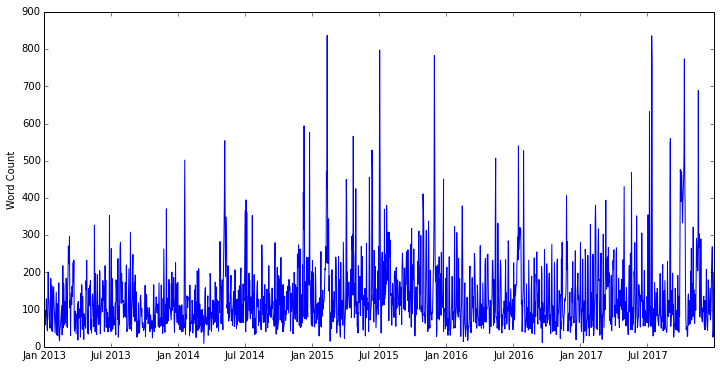

In [9]:
# Plot word count against date
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(diary['date'], diary['word_count'])
ax.set_ylabel('Word Count')
plt.show()

Extended periods of longer entries correspond to trips and holidays, e.g. February 2015 (honeymoon), July 2016 (first visit home after emigrating) and October 2017 (Tibet).

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


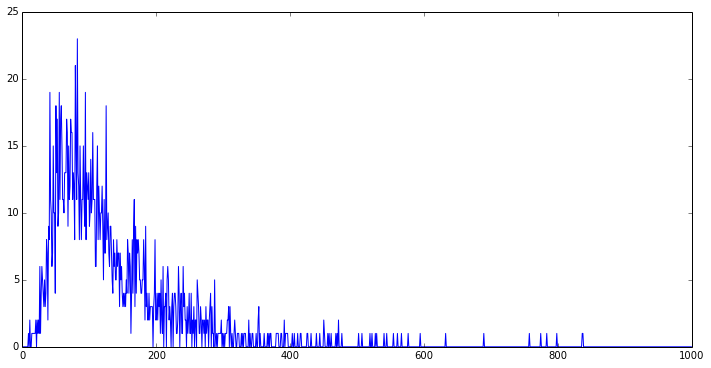

In [10]:
# Build a histogram of word counts
length_counts = np.zeros(1000)
for count in diary['word_count']:
    length_counts[count] += 1

# Plot word count histogram
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(length_counts)
fig.show()

In [11]:
# Add a column for cleaned words
def tokenize_words(text):
    non_alphanum_pattern = re.compile('[^\w ]')
    return non_alphanum_pattern.sub('', text.lower()).split()

diary['words'] = diary.apply(lambda row: tokenize_words(row['text']), axis=1)

In [12]:
# Get all the words
all_words = [word for words in list(diary['words']) for word in words]
print('The entire diary is ' + str(len(all_words)) + ' words.')
print('The average entry length is ' + str(int(len(all_words)/len(diary))) + ' words.')

The entire diary is 241704 words.
The average entry length is 132 words.


In [13]:
# Count occurences of each word
counts = defaultdict(lambda: 0)
for word in all_words:
    counts[word] += 1

word_counts = pd.DataFrame.from_records(list(counts.items()))
word_counts.columns = ['word', 'count']
word_counts = word_counts.sort(columns='count', ascending=False)

display(word_counts.head(20))

,word,count
9183,the,13696
56,and,11982
11711,a,7252
2387,to,7211
7215,i,6182
6042,in,4515
276,of,4185
11395,we,3601
1294,was,3501
13317,for,2935


In [14]:
stopwords = []
with open('stopword.txt') as f:
    for line in f:
        stopwords.append(line[:-1])
        
word_counts_without_stopwords = word_counts[word_counts.apply(lambda row: row['word'] not in stopwords, axis=1)]

display(word_counts_without_stopwords.head(20))

,word,count
1419,went,1735
4074,evening,1375
5294,katy,1230
12803,back,1061
14247,day,1023
4267,morning,950
6319,got,908
9233,work,776
8870,home,700
4611,afternoon,697


In [15]:
# Load a list of names I pulled off the internet
names = []
with open('boys-names.txt') as f:
    for line in f:
        names.append(line[:-1].lower().strip())
with open('girls-names.txt') as f:
    for line in f:
        names.append(line[:-1].lower().strip())
names = set(names)

# Add some crucial ones that are missing
names.add("katy")
names.add("briony")
names.add("mummy")
names.add("daddy")
names.add("niki")
names.add("konrad")
names.add("tom")
names.add("stacey")
names.add("jonno")
names.add("fran")
names.add("bodz")
names.add("kat")
names.add("lewi")
names.add("fi")
names.add("david")
names.add("rob")
names.add("noore")
names.add("milly")
names.add("pete")
names.add("keith")
names.add("alastair")
names.add("crispin")
names.add("eddy")
names.add("clare")
names.add("nick")
names.add("tim")
names.add("jens")

# Remove some words that are more usually not names of people
names.remove("river")
names.remove("sky")
names.remove("miles")
names.remove("london")
names.remove("grey")
names.remove("ridge")
names.remove("francisco")
names.remove("austin")
names.remove("antonio")
names.remove("crew")
names.remove("case")
names.remove("hope")
names.remove("summer")
names.remove("marina")
names.remove("henley")
names.remove("king")
names.remove("major")
names.remove("rose")
names.remove("drew")
names.remove("winter")
names.remove("journey")
names.remove("rocky")
names.remove("chance")
names.remove("jesus")
names.remove("america")

# That was a shitty list
        
name_counts = word_counts[word_counts.apply(lambda row: row['word'] in names, axis=1)]

display(name_counts.head(50))

,word,count
5294,katy,1230
8250,emily,231
3710,will,156
8359,jonno,140
12916,chris,133
195,niki,132
11579,stacey,128
10984,max,124
7430,tom,106
536,henry,103


Unsurprisingly, the name of my wife is at the top by a long way. "Will" is up there principally because of his roll as an auxiliary verb, but I didn't exclude this because I do know a couple of Wills who are mentioned quite frequently. "Emily" and "Chris" are/were both housemates for lengthy periods. The other highest-scorers are rowing buddies who I spent most of 2013-2014 training with. Then there's a load of close friends, family and sailing teammates.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

clean_content = [" ".join(words) for words in diary['words']]
count_vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    stop_words='english'
)
X = count_vectorizer.fit_transform(clean_content)
feature_names = count_vectorizer.get_feature_names()

In [17]:
def display_top_words_for_class(feature_names, classifier, idx, n=20):
    word_weights = pd.DataFrame.from_records(list(zip(feature_names, classifier.coef_[idx])))
    word_weights.columns = ['word', 'weight']
    word_weights['weight_magnitude'] = word_weights.apply(lambda row: np.abs(row['weight']), axis=1)
    word_weights = word_weights.sort(columns='weight_magnitude', ascending=False)
    display(word_weights.head(n))

In [18]:
# Predict year
year_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000).fit(X, diary['year'])

for idx in range(5):
    display_top_words_for_class(feature_names, year_classifier, idx)

,word,weight,weight_magnitude
3518,katy,-1.355757,1.355757
3519,katys,-1.077423,1.077423
2995,heartbeat,0.914226,0.914226
6599,tesco,-0.907232,0.907232
5563,run,-0.878061,0.878061
4513,outing,0.864666,0.864666
4752,piano,0.815819,0.815819
5549,rowing,0.752729,0.752729
6424,supervising,0.699441,0.699441
7225,wind,0.659244,0.659244


,word,weight,weight_magnitude
4620,particle,1.417174,1.417174
3519,katys,1.233377,1.233377
6599,tesco,1.207133,1.207133
7167,weights,0.822310,0.822310
2142,emily,-0.806220,0.806220
3518,katy,0.759213,0.759213
747,book,0.749417,0.749417
3669,learning,0.737472,0.737472
4513,outing,0.696585,0.696585
7108,want,0.657040,0.657040


,word,weight,weight_magnitude
1684,data,0.904419,0.904419
5248,recipe,0.861969,0.861969
4681,peer39,0.800558,0.800558
5190,ran,0.790465,0.790465
4593,paper,0.774023,0.774023
5074,ptp,0.770993,0.770993
6599,tesco,0.755976,0.755976
3740,linear,0.741236,0.741236
4513,outing,-0.662405,0.662405
1474,cooked,0.661015,0.661015


,word,weight,weight_magnitude
3532,keyword,1.429509,1.429509
3533,keywords,1.156588,1.156588
1756,demographic,0.875390,0.875390
5368,reporting,0.767734,0.767734
3494,jumpshot,0.761630,0.761630
4620,particle,-0.701579,0.701579
4141,modeling,0.701136,0.701136
6599,tesco,-0.695048,0.695048
2289,experimental,0.688384,0.688384
4014,meetings,0.675819,0.675819


,word,weight,weight_magnitude
657,bidder,1.280917,1.280917
871,budgeter,1.277751,1.277751
1455,controller,0.956172,0.956172
2288,experiment,0.805854,0.805854
5728,search,0.760220,0.760220
1407,config,0.752299,0.752299
797,brand,0.752008,0.752008
659,bidding,0.750078,0.750078
1453,control,0.741569,0.741569
1774,deploy,0.685593,0.685593


In [19]:
# Predict month
y = [months.index(month) for month in diary['month']]
month_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000).fit(X, y)

for idx in range(12):
    print("Top words for " + months[idx])
    display_top_words_for_class(feature_names, month_classifier, idx, n=10)

Top words for January


,word,weight,weight_magnitude
658,bidders,0.951503,0.951503
5048,proposals,0.850039,0.850039
3264,inference_utils,0.778048,0.778048
4476,optimal,0.772390,0.772390
4646,patent,0.750243,0.750243
5953,skiing,0.727797,0.727797
6532,targeting,0.668606,0.668606
3987,mcmc,0.667249,0.667249
5047,proposal,0.652573,0.652573
5041,proofreading,0.620380,0.620380


Top words for February


,word,weight,weight_magnitude
656,bid,0.958486,0.958486
797,brand,0.904944,0.904944
2273,existing,0.755121,0.755121
6013,smon,0.750560,0.750560
521,backward,0.703067,0.703067
657,bidder,0.696173,0.696173
2558,forecasting,0.653688,0.653688
1203,circuits,0.647698,0.647698
2288,experiment,-0.627460,0.627460
1684,data,-0.610286,0.610286


Top words for March


,word,weight,weight_magnitude
6705,tired,0.604976,0.604976
7304,writeup,0.600779,0.600779
3839,lovely,0.594408,0.594408
1268,cluster,0.588806,0.588806
7225,wind,0.586861,0.586861
6876,tv,0.581881,0.581881
3958,match,0.562375,0.562375
657,bidder,0.561259,0.561259
2288,experiment,-0.559739,0.559739
2035,drove,-0.558092,0.558092


Top words for April


,word,weight,weight_magnitude
960,camp,0.878911,0.878911
476,aurora,0.714004,0.714004
6278,stochastic,0.691920,0.691920
2874,grumpy,0.688452,0.688452
3402,james,0.687502,0.687502
5329,relaxed,0.676289,0.676289
5165,racing,0.653978,0.653978
3414,jc,0.648947,0.648947
871,budgeter,-0.606071,0.606071
6424,supervising,0.594553,0.594553


Top words for May


,word,weight,weight_magnitude
871,budgeter,1.113601,1.113601
5458,rich,0.821378,0.821378
6602,test,0.744167,0.744167
6428,supf,0.730947,0.730947
6225,starts,0.715836,0.715836
6175,sql,0.705919,0.705919
6569,tedious,0.690929,0.690929
6095,spaced,0.668871,0.668871
7134,watching,-0.647139,0.647139
2212,error,0.646459,0.646459


Top words for June


,word,weight,weight_magnitude
871,budgeter,0.865668,0.865668
4849,poem,0.757969,0.757969
3029,henley,0.706272,0.706272
4513,outing,0.686750,0.686750
7309,wrote,0.684607,0.684607
5929,simulations,0.672794,0.672794
955,cambridge,0.663700,0.663700
6898,umbel,0.638886,0.638886
7277,worked,0.603609,0.603609
7160,weekend,0.587214,0.587214


Top words for July


,word,weight,weight_magnitude
889,bumps,1.179075,1.179075
1455,controller,0.989892,0.989892
992,car,0.700848,0.700848
2995,heartbeat,0.692069,0.692069
3832,lots,0.668969,0.668969
3739,line,0.659274,0.659274
1088,changed,0.657959,0.657959
4800,place,0.621363,0.621363
4593,paper,0.620086,0.620086
2136,emba,0.607094,0.607094


Top words for August


,word,weight,weight_magnitude
676,birthday,0.899453,0.899453
4513,outing,-0.795271,0.795271
1455,controller,0.769153,0.769153
5715,scull,0.737935,0.737935
1777,deployment,0.719827,0.719827
3494,jumpshot,0.688592,0.688592
5026,progress,0.671750,0.671750
622,beer,0.664011,0.664011
3524,keith,0.662501,0.662501
6659,throttle,0.624825,0.624825


Top words for September


,word,weight,weight_magnitude
2620,frequency,0.818621,0.818621
6316,stretches,0.710726,0.710726
4755,pick,0.698331,0.698331
2674,galavant,0.691059,0.691059
4513,outing,-0.679717,0.679717
4014,meetings,0.642281,0.642281
5733,season,0.638387,0.638387
6494,systematic,0.637445,0.637445
7264,wonderful,0.633414,0.633414
653,better,0.632575,0.632575


Top words for October


,word,weight,weight_magnitude
6627,thesis,1.057694,1.057694
2517,flow,0.910654,0.910654
5368,reporting,0.792513,0.792513
7166,weight,0.781143,0.781143
1550,cppf,0.718607,0.718607
297,analysis,0.702922,0.702922
200,admin,0.688526,0.688526
2699,gave,0.677341,0.677341
1291,code,-0.612862,0.612862
505,awkward,0.603898,0.603898


Top words for November


,word,weight,weight_magnitude
4681,peer39,1.340271,1.340271
5206,rate,1.117461,1.117461
5368,reporting,1.084449,1.084449
5691,scoring,1.005565,1.005565
7008,variable,0.893885,0.893885
4926,pppf,0.884861,0.884861
1684,data,0.785330,0.785330
2685,gaps,0.681814,0.681814
6190,stacey,0.661547,0.661547
3854,lunch,0.657709,0.657709


Top words for December


,word,weight,weight_magnitude
1186,christmas,1.555379,1.555379
4585,panel,0.917745,0.917745
7090,wais,0.805642,0.805642
3336,interviewing,0.783654,0.783654
1756,demographic,0.743146,0.743146
1099,chapter,0.725379,0.725379
3518,katy,0.687818,0.687818
3538,kids,0.644755,0.644755
3977,max,0.597511,0.597511
6599,tesco,-0.581505,0.581505


In [20]:
# Predict weekday
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
y = [weekdays.index(weekday) for weekday in diary['weekday']]
weekday_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000).fit(X, y)

for idx in range(7):
    print("Top words for " + weekdays[idx])
    display_top_words_for_class(feature_names, weekday_classifier, idx, n=10)

Top words for Mon


,word,weight,weight_magnitude
7167,weights,1.490861,1.490861
5967,slept,-0.818129,0.818129
3333,interview,0.735743,0.735743
4354,noriega,0.720026,0.720026
6599,tesco,-0.717005,0.717005
955,cambridge,0.689700,0.689700
1186,christmas,0.637346,0.637346
7308,wrong,0.631517,0.631517
5913,silicon,0.589620,0.589620
4901,postdoc,0.586385,0.586385


Top words for Tue


,word,weight,weight_magnitude
6173,sprint,1.336251,1.336251
5435,review,1.278864,1.278864
6181,squash,0.852891,0.852891
1867,dinner,-0.766765,0.766765
7150,weather,0.725618,0.725618
4432,ok,0.712032,0.712032
2933,handling,0.680318,0.680318
6424,supervising,0.670864,0.670864
7278,working,0.640624,0.640624
4014,meetings,0.620416,0.620416


Top words for Wed


,word,weight,weight_magnitude
3885,mainly,0.854112,0.854112
4013,meeting,0.799003,0.799003
4811,planning,0.794192,0.794192
1495,core,0.791127,0.791127
4613,parkside,0.773731,0.773731
6604,testing,0.750251,0.750251
622,beer,-0.666134,0.666134
3444,job,0.656426,0.656426
236,agreed,0.641366,0.641366
6569,tedious,0.630573,0.630573


Top words for Thu


,word,weight,weight_magnitude
1203,circuits,0.841460,0.841460
7309,wrote,0.766063,0.766063
6599,tesco,-0.757791,0.757791
5763,seminar,0.727718,0.727718
3839,lovely,-0.715159,0.715159
6993,ut2,0.701244,0.701244
188,adding,-0.690150,0.690150
5446,rewrite,0.625362,0.625362
684,bits,-0.618186,0.618186
622,beer,-0.582125,0.582125


Top words for Fri


,word,weight,weight_magnitude
622,beer,0.994473,0.994473
2949,happy,0.980755,0.980755
3157,hung,0.782620,0.782620
3132,hour,0.744344,0.744344
7167,weights,-0.737478,0.737478
5563,run,-0.716569,0.716569
4971,pretty,0.711157,0.711157
1649,cycled,-0.672725,0.672725
6236,stay,0.665581,0.665581
2018,drink,0.640564,0.640564


Top words for Sat


,word,weight,weight_magnitude
5967,slept,0.749200,0.749200
5943,sitting,0.744147,0.744147
5741,second,0.740474,0.740474
6414,sunny,0.739217,0.739217
3710,lie,0.676330,0.676330
3414,jc,0.675458,0.675458
5864,shopping,0.612265,0.612265
2969,having,0.586053,0.586053
1648,cycle,0.564682,0.564682
5180,raining,0.539629,0.539629


Top words for Sun


,word,weight,weight_magnitude
2361,family,1.497113,1.497113
858,brunch,1.174661,1.174661
3658,lazy,0.920591,0.920591
7326,yesterday,0.662708,0.662708
7127,washing,0.648621,0.648621
7133,watched,0.636248,0.636248
4123,miss,0.602897,0.602897
7115,warm,0.576267,0.576267
7160,weekend,0.567462,0.567462
500,away,0.564935,0.564935


In [21]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=20,
    learning_method='batch',
    max_iter=10,
    learning_offset=50.0,
    random_state=0).fit(X)

In [22]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(lda, feature_names, 20)

Topic #0: evening work day spent today morning katy good really tesco time linear working started got data paper learning afternoon trying
Topic #1: went got katy morning niki dinner konrad evening bit day time did good boat afternoon played arrived granny came today
Topic #2: went katy drove beach way morning little day walked time sun lunch home dinner got great evening valley took afternoon
Topic #3: went katy evening work good day morning really got time quite dinner home did afternoon bit felt spent just today
Topic #4: katy river went chat hotel water just came walked lake day welcome lunch little night time stopped way pleasant late
Topic #5: work bidder evening changes today experimental went spent code budgeter review morning brand deployed afternoon working day experiment katy keyword
Topic #6: evening day really spent morning meetings went started worked afternoon work bit katy planning sprint home working good new finished
Topic #7: particle flow evening work got progress w